In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv("yahoo_stock.csv")

data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
data.shape

(1825, 7)

In [4]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912



**EDA**


In [5]:
data.isnull().sum()

,0
Date,0
High,0
Low,0
Open,0
Close,0
Volume,0
Adj Close,0


**Date parsing and indexing**

In [6]:
data["Date"] = pd.to_datetime(data["Date"])

In [7]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


**Time Series visualization using interactive graphs**

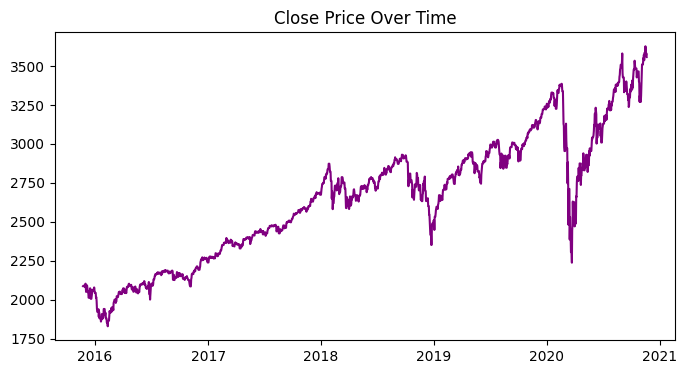

In [8]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the line chart
ax.plot(data['Date'], data['Close'], color="purple")

# Customize the background color (transparent)
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Set the title
ax.set_title("Close Price Over Time")

# Display the plot
plt.show()



**Volume Analysis**

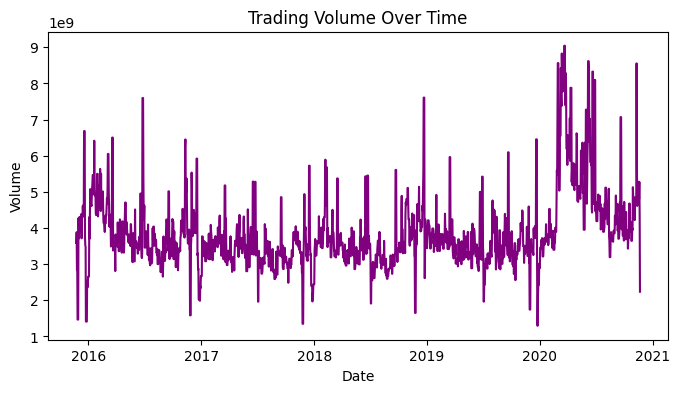

In [9]:
# Create a figure and axis with the specified size
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the line chart for Trading Volume
ax.plot(data['Date'], data['Volume'], color="purple")

# Customize the background color (transparent)
fig.patch.set_facecolor('none')  # Background for the figure
ax.set_facecolor('none')         # Background for the plot area

# Set the title
ax.set_title("Trading Volume Over Time")

# Set labels (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Volume")

# Display the plot
plt.show()

**Rolling Statistics**

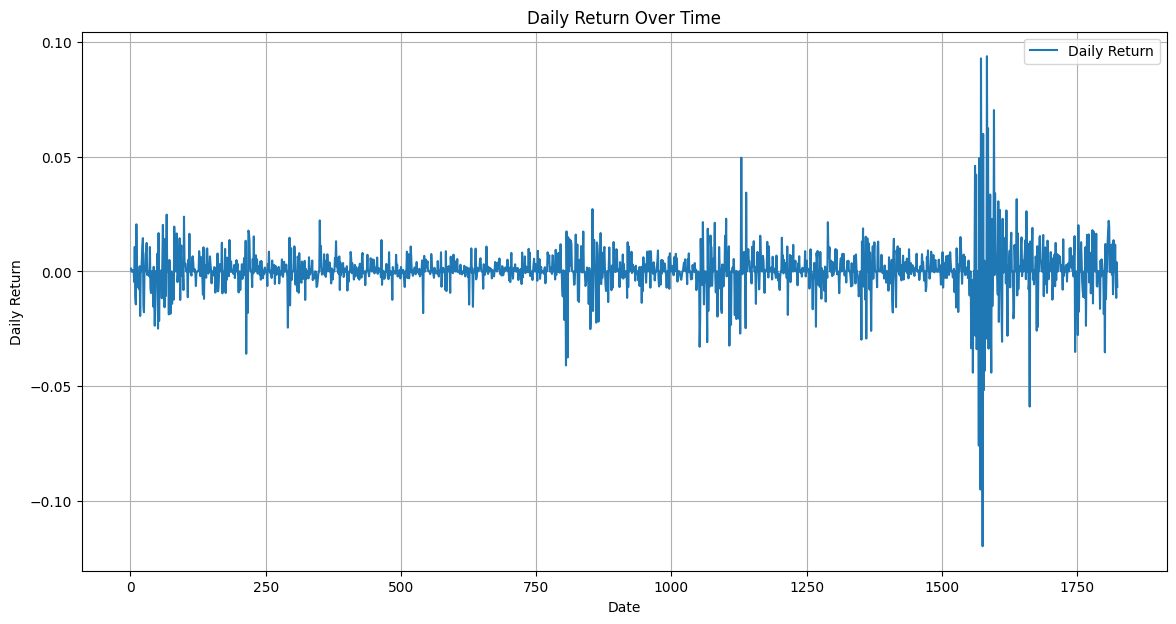

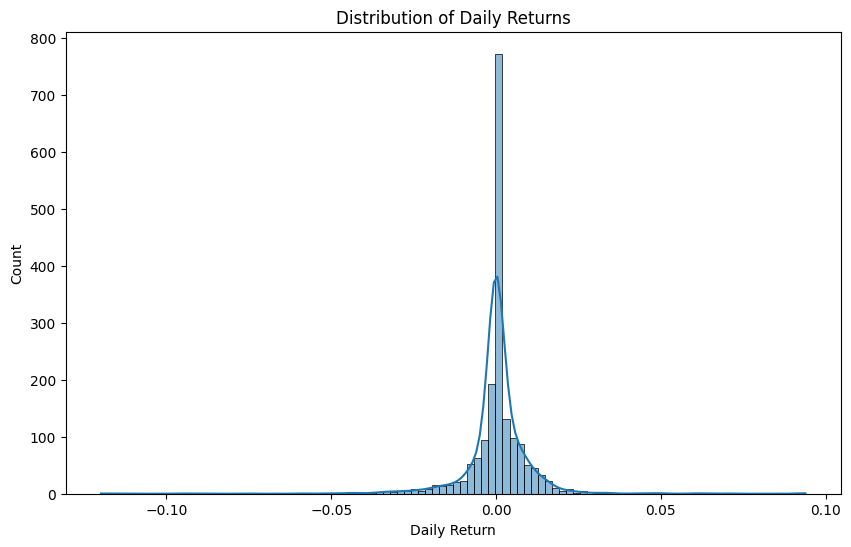

In [10]:
data["Daily Return"] = data["Close"].pct_change()
plt.figure(figsize=(14,7))
plt.plot(data["Daily Return"],label="Daily Return")
plt.title("Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
sns.histplot(data['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.show()

**Seasonal Decomposition for separating the time series into trend, seasonality, and residual components**

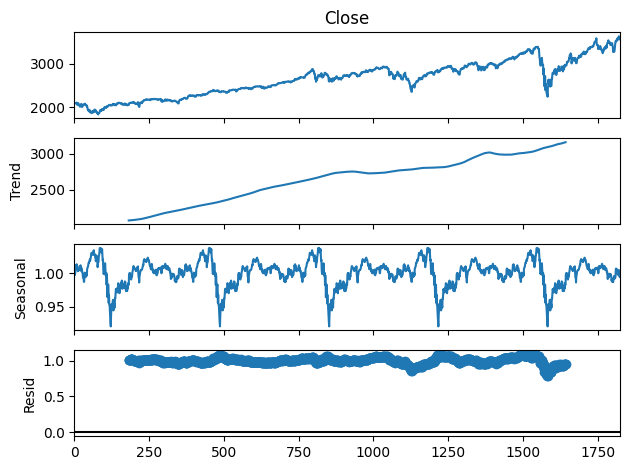

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["Close"],model="multiplicative",period=365)
result.plot()
plt.show()

**Some Correlation Analysis**

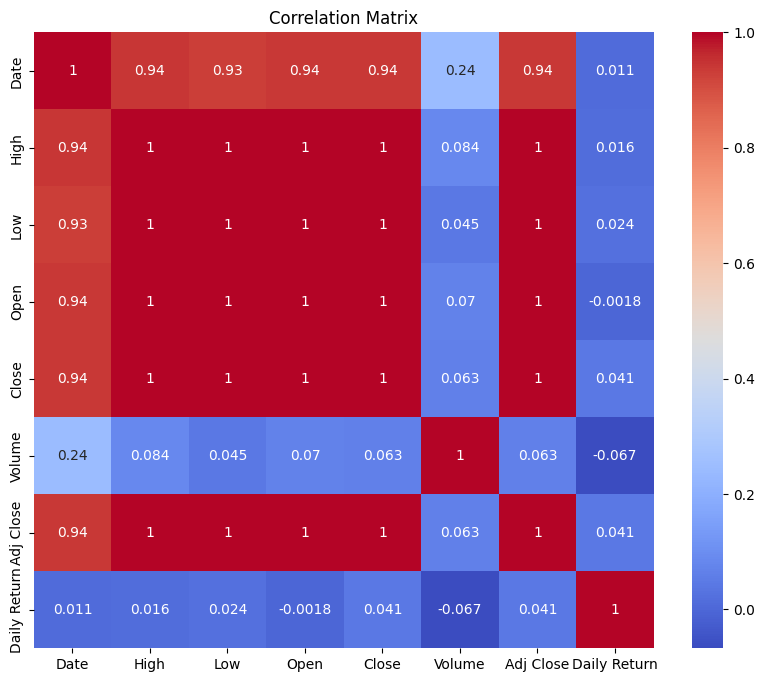

In [12]:
corr_matrix =data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

**LSTM Time Series Forcasting**

**prepare Data**

In [13]:
from sklearn.preprocessing import MinMaxScaler

close_data = data[["Close"]]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 50
X, y = create_sequences(scaled_data, sequence_length)

In [14]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Bulid and Complie the LSTM (RNN) Model**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation = "relu", input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0859 - val_loss: 0.0143
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - val_loss: 0.0104
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5492e-04 - val_loss: 0.0067
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6256e-04 - val_loss: 0.0048
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.8993e-04 - val_loss: 0.0030
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.6296e-04 - val_loss: 0.0027
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2104e-04 - val_loss: 0.0024
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2135e-04 - val_loss: 0.0021
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6035e-04 - val_loss: 0.0019
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7610e-04 - val_loss: 0.0021
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.1303e-04 - val_loss: 0.0017
Epoch 12/20
45/45 ━━━━━━━━━

In [17]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Test Loss: 0.0012723542749881744


In [18]:
# Make predictions
y_pred = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [19]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

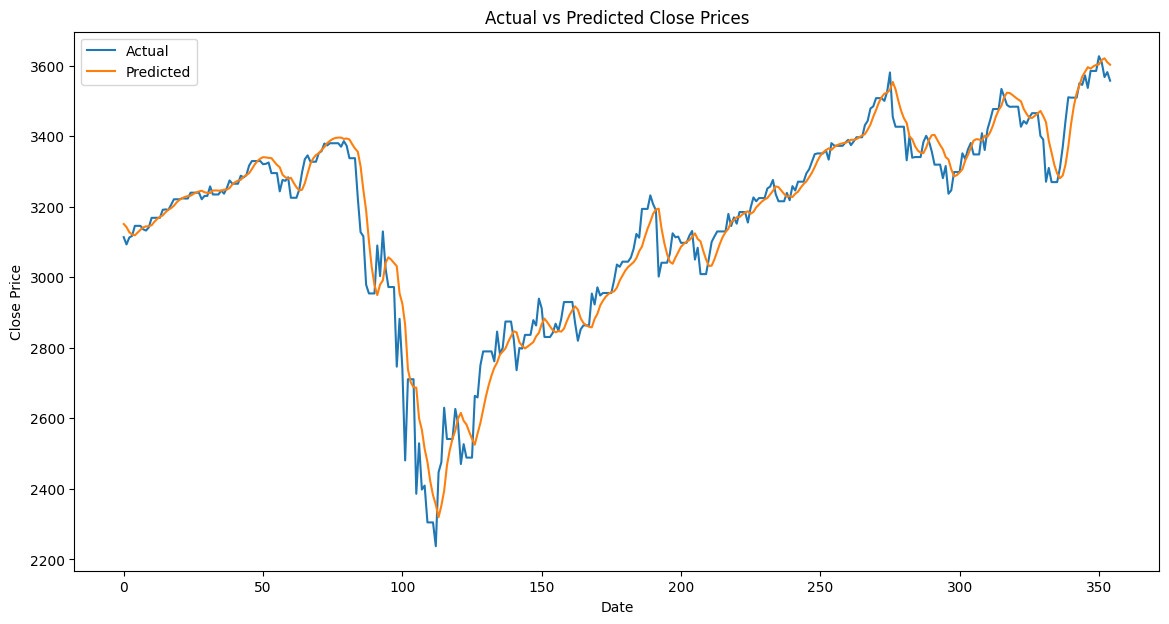

In [20]:
plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()